# The fast spectral method

By choosing the test function $\phi(v) = e^{-i\frac{\pi}{L} k\cdot v}$ in the weak form, we can obtain the Fourier expansion of $Q$:

$$\hat{Q}_k= \sum_{\substack{l,m=-\frac{N}{2}\\l+m=k}}^{\frac{N}{2}-1} G(l,m) \hat{f}_l \hat{f}_m\,,$$

where the weight $G(l,m)$ is given by

$$
G(l,m)=\int_{\mathbb{R}^d}e^{-i\frac{\pi}{L}m \cdot g}\bigg[\int_{S^{d-1}}B_{\sigma}(\lvert g\rvert,\sigma\cdot \hat{g})\left(e^{-i\frac{\pi}{L}\frac{1+e}{4}(l+m)\cdot (|g|\sigma-g)}-1\right)\,\mathrm{d}{\sigma}\bigg]\,\mathrm{d}{g} \,,
$$

where $g$ needs to be truncated properly as was done for the elastic case. 

The idea of the fast algorithm is to separate the weight $G$ as $G(l,m)\approx\sum_{t=1}^T\alpha_t(l+m)\beta_t(m)$ using quadrature rules.

In [1]:
%matplotlib inline
import numpy as np
from math import pi
from scipy import special
import matplotlib.pyplot as plt
import pyfftw

import sys
sys.path.append('../src')
from fast_spec_col_2d import FastSpectralCollison2D
from utility import get_config, plot_2d

## 2D case

In 2D, and VHS case $B_{\sigma}(|g|,\sigma\cdot \hat{g})=C_{\gamma}|g|^{\gamma}$:

$$
\int_{S^1}B_{\sigma}(|g|,\sigma\cdot \hat{g})\left(e^{-i\frac{\pi}{L}\frac{1+e}{4}(l+m)\cdot (|g|\sigma-g)}-1\right)\,\mathrm{d}{\sigma}=2\pi C_{\gamma}|g|^{\gamma}\left[ e^{i\frac{\pi}{L}\frac{1+e}{4}(l+m)\cdot g}\text{J}_0\left(\frac{\pi}{L}\frac{1+e}{4}|l+m||g|\right)-1\right],
$$

then let $\rho=|g|$, $\sigma=\hat{g}$,

$$
G(l,m)=\sum_{\rho,\sigma}w_{\rho}w_{\sigma}2\pi C_{\gamma}\rho^{\gamma+1}e^{-i\frac{\pi}{L}\rho m \cdot \sigma}\left[ e^{i\frac{\pi}{L}\frac{1+e}{4}\rho (l+m)\cdot \sigma}\text{J}_0\left(\frac{\pi}{L}\frac{1+e}{4}|l+m|\rho\right)-1\right],
$$

therefore,

$$ 
\hat{Q}_k=\sum_{\rho,\sigma}w_{\rho}w_{\sigma}2\pi C_{\gamma}\rho^{\gamma+1}\left[ e^{i\frac{\pi}{L}\frac{1+e}{4}\rho k\cdot \sigma}\text{J}_0\left(\frac{\pi}{L}\frac{1+e}{4}\rho |k|\right)-1\right]\sum_{\substack{l,m=-\frac{N}{2}\\l+m=k}}^{\frac{N}{2}-1}\hat{f}_l \left[e^{-i\frac{\pi}{L}\rho m \cdot \sigma}\hat{f}_m\right],
$$

or the loss term can be computed separately as

$$ 
\hat{Q}_k^-=\sum_{\rho,\sigma}w_{\rho}w_{\sigma}2\pi C_{\gamma}\rho^{\gamma+1}\sum_{\substack{l,m=-\frac{N}{2}\\l+m=k}}^{\frac{N}{2}-1}\hat{f}_l \left[e^{-i\frac{\pi}{L}\rho m \cdot \sigma}\hat{f}_m\right]=\sum_{\rho}w_{\rho}4\pi^2 C_{\gamma}\rho^{\gamma+1}\sum_{\substack{l,m=-\frac{N}{2}\\l+m=k}}^{\frac{N}{2}-1}\hat{f}_l \left[\text{J}_0\left(\frac{\pi}{L}\rho |m|\right)\hat{f}_m\right].
$$

## 2D accuracy test

Maxwell molecule:

$$
B_\sigma(|g|, \sigma\cdot \hat{g}) = C_0 b_0(\sigma\cdot\hat{g}).
$$

Initial value

$$f(t,v) = \frac{1}{2\pi K^2}\exp\left(-\frac{v^2}{2K}\right)\left(2K - 1 + \frac{1-K}{2K}v^2\right), $$

where $K = 1 - \exp(-t/8)/2$.

According to Boltzmann equation

$$\frac{\partial f}{\partial t} = Q(f),$$

The exact vaule of $Q(f)$ is

$$\frac{\partial f}{\partial t} = \left\{\left(-\frac{2}{K}+\frac{v^2}{2K^2}\right) f + \frac{1}{2\pi K^2}\exp\left(-\frac{v^2}{2K}\right)\left(2-\frac{v^2}{2K}\right)\right\}K',$$

where $K'=\exp(-t/8)/16$.

In [2]:
def bkw_f(v):
    t = 0.5
    K = 1 - 0.5*np.exp(-t/8)
    v_norm = (v**2)[:,None] + v**2
    return 1/(2*pi*K**2)*np.exp(-0.5*v_norm/K)*(2*K-1+0.5*v_norm*(1-K)/K)

def ext_Q(v):
    t = 0.5
    K = 1 - np.exp(-t/8)/2
    dK = np.exp(-t/8)/16
    v_norm = (v**2)[:,None] + v**2
    df = (-2/K+v_norm/(2*K**2))*bkw_f(v) + 1/(2*pi*K**2)*np.exp(-v_norm/(2*K))*(2-v_norm/(2*K**2))
    return df*dK

In [7]:
config = get_config('../src/configs/config.json')
Q = FastSpectralCollison2D(config)

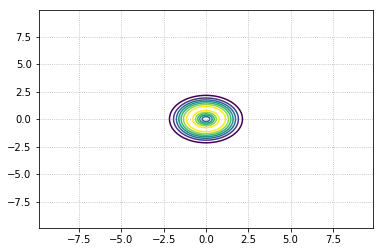

In [8]:
f0 = bkw_f(Q.v)
plot_2d(f0, Q.v, 0)

In [9]:
%time Q1 = Q.col_full(bkw_f(Q.v))/(2*pi)
%time Q2 = Q.col_sep(bkw_f(Q.v))/(2*pi)
np.max(np.abs(Q1 - ext_Q(Q.v))), np.max(np.abs(Q2 - ext_Q(Q.v)))

Wall time: 3.45 s
Wall time: 3 s


(1.314789471618268e-10, 1.0130785099704553e-15)

In [10]:
def anisotropic_f(v):
    return 0.8/pi*(np.exp(-(v-2)[:,None]**2/0.25-(v-2)**2/0.25) + np.exp(-(v+0.5)[:,None]**2-(v+0.5)**2))

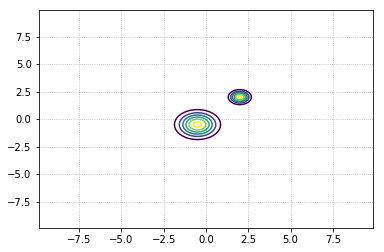

In [11]:
f0 = anisotropic_f(Q.v)
plot_2d(f0, Q.v, 0)

We also have $\rho_0 = 1$, $u_0 = 0$, $E = T$. Temperature $T$ safisfies:

$$
T=\left(T_0-\frac{8\varepsilon}{1-e^2}\right)\exp{\left(-\frac{1-e^2}{4}t\right)}+\frac{8\varepsilon}{1-e^2}.
$$

### Numerical Scheme

In [ ]:
from test_2D import TestModule2D
config_2D = get_config('./configs/config_2D.json')

In [11]:
def plot_err(x, err, rate, name):
    fig, ax = plt.subplots()
    ax.loglog(x, err, 'o-', label='numerical error of $T$')
    ax.loglog(x, np.asarray(x)**rate, label='reference: 3-order')
    ax.set_xlabel('$\Delta t$')
    ax.set_ylabel('error of $T$')
    ax.set_title('Convergence of RK3 in $\Delta t$')
    ax.legend(fontsize='large')
    ax.grid(which='both',linestyle=':')
    plt.savefig(name)
    plt.show()

### Time convergence 1

In [3]:
%%time
config_2D.domain_config.S = 3.9
N = [16, 32, 64]
test = TestModule2D(config_2D, bkw_f, N, 0.2, eps=1e-6)

Wall time: 852 ms


In [4]:
%%time
# Dt = [0.1, 0.05, 0.02, 0.01, 0.005]
# Dt = [0.5, 0.4, 0.2, 0.1, 0.05, 0.04, 0.02, 0.01]
# Dt = [0.1]
Dt = [0.5, 0.1, 0.01]
err, num_f, num_T = test.dt_test(Dt, method='full', N_index=2)

Wall time: 2min 36s


In [ ]:
np.savez('dt_2d_bgk_e_full=0.2', dt=Dt, err=err, num_T=num_T, num_f=num_f)

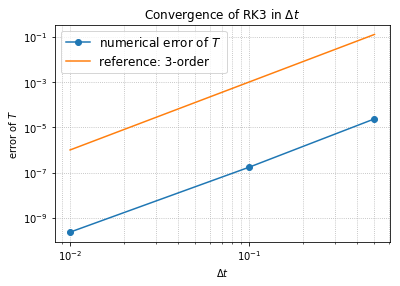

In [7]:
plot_err(Dt, err, 3, 'dt_2d_bgk_e_full=0.2.pdf')

### Time convergence 2

In [17]:
%%time
config_2D.domain_config.S = 4.0
N = np.array([8, 16, 32, 64, 128])
test = TestModule(config_2D, anisotropic_f, N, 0.2, eps=1e-6)

CPU times: user 4.53 s, sys: 503 ms, total: 5.03 s
Wall time: 5.03 s


In [ ]:
%%time
Dt = [0.5, 0.4, 0.2, 0.1, 0.05, 0.04, 0.02, 0.01]
# Dt = [1, 0.8, 0.7, 0.6, 0.5]
err, num_f, num_T = test.dt_test(Dt, method='full')

In [ ]:
np.savez('dt_2d_e_full=0.2', dt=Dt, err=err, num_T=num_T, num_f=num_f)
plot_err(Dt, err, 3, 'dt_2d_e_full=0.2.pdf')

### N convergence 1

In [ ]:
%%time
config_2D.domain_config.S = 3.9

N = np.array([8, 16, 32, 64, 128])
test = TestModule(config_2D, bkw_f, N, 0.2, eps=1e-6)

In [ ]:
%%time
dt = 0.01
err_N, num_f, num_T = test.N_test(dt, method='full')

In [ ]:
np.savez('N_2d_bgk_e_full=0.2', N=N, err=err_N, num_T=num_T, num_f=num_f)

**$\text{tfinal} = 2$, $\Delta t = 0.01$, $e = 0.2$**

| $N$ | Separate | Full |
| ------ | ------ | ------|
| 8 | 9.21116565e-01 | 9.21116565e-01 |
| 16 | 1.27634481e-02 |1.27640374e-02 |
| 32 | 6.79544555e-06 | 6.79745658e-06 |
| 64 | 2.34851361e-10 | 2.36438646e-10 |
| 128 | 6.30565600e-11 | 6.13890050e-11 |

**$\text{tfinal} = 2$, $\Delta t = 0.01$, $e = 0.5$**

| $N$ | Separate | Full |
| ------ | ------ | ------ |
| 8 | 7.98706096e-01 | 7.98706096e-01 |
| 16 | 6.42641236e-03 | 6.42644165e-03 |
| 32 | 4.55713801e-06 | 4.55730861e-06 |
| 64 | 4.93595165e-11 | 4.93770580e-11 |
| 128 | 3.13873372e-11 | 3.14279713e-11 |

**$\text{tfinal} = 2$, $\Delta t = 0.01$, $e = 0.8$**

| $N$ | Separate | Full |
| ------ | ------ | ------|
| 8 | 5.52666966e-01 | 5.52666966e-01 |
| 16 | 4.88821204e-04 | 4.88586534e-04  |
| 32 | 1.14430393e-07 | 1.13897201e-07   |
| 64 | 9.82359749e-11 | 9.82520731e-11   |
| 128 | 1.00099595e-10 | 1.00117470e-10   |

### N convergence 2

In [ ]:
%%time
config_2D.domain_config.S = 4.0

N = np.array([8, 16, 32, 64, 128])

test2 = TestModule(config_2D, anisotropic_f, N, 0.2, eps=1e-6)
test5 = TestModule(config_2D, anisotropic_f, N, 0.5, eps=1e-6)
test8 = TestModule(config_2D, anisotropic_f, N, 0.8, eps=1e-6)

dt = 0.01

err_N2, num_f2, num_T2 = test2.N_test(dt)
err_N5, num_f5, num_T5 = test5.N_test(dt)
err_N8, num_f8, num_T8 = test8.N_test(dt)

err_N2_full, num_f2_full, num_T2_full = test2.N_test(dt, method='full')
err_N5_full, num_f5_full, num_T5_full = test5.N_test(dt, method='full')
err_N8_full, num_f8_full, num_T8_full = test8.N_test(dt, method='full')


np.savez('N_2d_e=0.2', N=N, err=err_N2, num_T=num_T2, num_f=num_f2)
np.savez('N_2d_e=0.5', N=N, err=err_N5, num_T=num_T5, num_f=num_f5)
np.savez('N_2d_e=0.8', N=N, err=err_N8, num_T=num_T8, num_f=num_f8)

np.savez('N_2d_e_full=0.2', N=N, err=err_N2_full, num_T=num_T2_full, num_f=num_f2_full)
np.savez('N_2d_e_full=0.5', N=N, err=err_N5_full, num_T=num_T5_full, num_f=num_f5_full)
np.savez('N_2d_e_full=0.8', N=N, err=err_N8_full, num_T=num_T8_full, num_f=num_f8_full)

**$\text{tfinal} = 2$, $\Delta t = 0.01$, $e = 0.2$**

| $N$ | Separate | Full |
| ------ | ------ | ------|
| 8 | 1.25303916e-01 | 1.25303916e-01 |
| 16 | 1.41601818e-02 |1.42811856e-02 |
| 32 | 1.21162093e-04 | 8.50383206e-05 |
| 64 | 8.65618628e-08 | 5.75217760e-05 |
| 128 | 2.64749862e-08 | 5.74603408e-05 |

**$\text{tfinal} = 2$, $\Delta t = 0.01$, $e = 0.5$**

| $N$ | Separate | Full |
| ------ | ------ | ------ |
| 8 | 9.06935081e-02 | 9.06935081e-02 |
| 16 | 2.06153352e-02 | 2.07345865e-02 |
| 32 | 1.08598123e-04 | 7.68575010e-05 |
| 64 | 3.61540865e-08 | 4.58166915e-05 |
| 128 | 4.84827622e-09 | 4.57852460e-05 |

**$\text{tfinal} = 2$, $\Delta t = 0.01$, $e = 0.8$**

| $N$ | Separate | Full |
| ------ | ------ | ------|
| 8 | 4.21932177e-02 | 4.21932177e-02 |
| 16 | 2.19257970e-02 | 2.17989934e-02  |
| 32 | 1.25546782e-04 | 1.17000137e-04   |
| 64 | 1.55334599e-08 | 2.42867607e-05   |
| 128 |  5.91159477e-09 | 2.42767854e-05   |